In [1]:
#Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from tensorflow import keras
from itertools import chain, combinations
import matplotlib.patches as mpatches

2024-05-22 17:45:46.204938: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 17:45:46.245081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 17:45:46.903454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## LOADING DATA

In [2]:
# Loading CIFAR10 and data split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

k = 20  # number of non-singleton focal sets 
num_classes = 10
input_shape = (32, 32, 3)  #standard CIFAR10 data shape

In [3]:
# Scaling images to [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_test_org = x_test

# Standard normalizing
x_train = (x_train - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])
x_test = (x_test - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])

y_train = y_train[:,0]
y_test = y_test[:,0]

# Validation split
val_samples = -10000

x_val = x_train[val_samples:]
y_val = y_train[val_samples:]

x_train = x_train[:val_samples]
y_train = y_train[:val_samples]

y_train_one_hot = tf.one_hot(y_train, num_classes)
y_test_one_hot = tf.one_hot(y_test, num_classes)
y_val_one_hot = tf.one_hot(y_val, num_classes)

2024-05-22 17:45:55.511005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 476 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-05-22 17:45:55.513480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21869 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-05-22 17:45:55.515236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22824 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:60:00.0, compute capability: 7.5
2024-05-22 17:45:55.516551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 476 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:61:00.0, compute 

In [4]:
# CIFAR10 classes
classes = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
# Dict of classes
num_clusters = len(classes)
classes_dict = {c:num for c,num in zip(classes, range(len(classes)))}
classes_dict_inverse = {num:c for c,num in zip(classes, range(len(classes)))}
classes_dict, classes_dict_inverse

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 {0: 'airplane',
  1: 'automobile',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck'})

In [6]:
# Load npy and pkl files
def load_npy(model_folder, filename):
    filepath = f"{model_folder}/{filename}"
    return np.load(filepath)

def load_pickle(model_folder, filename):
    filepath = f"{model_folder}/{filename}"
    with open(filepath, 'rb') as file:
        return pickle.load(file)

In [7]:
# Loading optimal subsets of classes
new_classes = load_pickle("CIFAR10", "new_classes.pkl")
new_classes

[{'airplane'},
 {'automobile'},
 {'bird'},
 {'cat'},
 {'deer'},
 {'dog'},
 {'frog'},
 {'horse'},
 {'ship'},
 {'truck'},
 {'automobile', 'deer'},
 {'bird', 'deer'},
 {'automobile', 'bird'},
 {'cat', 'frog'},
 {'automobile', 'ship'},
 {'deer', 'frog'},
 {'automobile', 'bird', 'deer'},
 {'cat', 'truck'},
 {'automobile', 'frog'},
 {'dog', 'horse'},
 {'bird', 'frog'},
 {'cat', 'deer'},
 {'bird', 'dog'},
 {'automobile', 'deer', 'frog'},
 {'horse', 'truck'},
 {'automobile', 'cat'},
 {'frog', 'ship'},
 {'cat', 'dog'},
 {'bird', 'deer', 'frog'},
 {'cat', 'horse'}]

In [8]:
# Adding the full set/universal set to new_classes
new_classes_with_full = new_classes + [set(classes)]
new_classes_with_full, len(new_classes_with_full)

([{'airplane'},
  {'automobile'},
  {'bird'},
  {'cat'},
  {'deer'},
  {'dog'},
  {'frog'},
  {'horse'},
  {'ship'},
  {'truck'},
  {'automobile', 'deer'},
  {'bird', 'deer'},
  {'automobile', 'bird'},
  {'cat', 'frog'},
  {'automobile', 'ship'},
  {'deer', 'frog'},
  {'automobile', 'bird', 'deer'},
  {'cat', 'truck'},
  {'automobile', 'frog'},
  {'dog', 'horse'},
  {'bird', 'frog'},
  {'cat', 'deer'},
  {'bird', 'dog'},
  {'automobile', 'deer', 'frog'},
  {'horse', 'truck'},
  {'automobile', 'cat'},
  {'frog', 'ship'},
  {'cat', 'dog'},
  {'bird', 'deer', 'frog'},
  {'cat', 'horse'},
  {'airplane',
   'automobile',
   'bird',
   'cat',
   'deer',
   'dog',
   'frog',
   'horse',
   'ship',
   'truck'}],
 31)

## LOADING PREDICTIONS

In [9]:
cnn_preds = load_npy("CIFAR10", "cnn_preds_cifar10.npy")
lbbnn_100_preds = load_npy("CIFAR10", "lbbnn_preds_cifar10_100.npy")
de_15_preds = load_npy("CIFAR10", "de_preds_cifar10_15.npy")
creinn_preds = load_pickle("CIFAR10", "creinn_preds_cifar10")
ecnn_preds = load_npy("CIFAR10", "ecnn_preds_cifar10_mass.npy")
rscnn_preds = load_npy("CIFAR10", "rscnn_preds_cifar10.npy")

In [10]:
print("Shape of CNN predictions:", cnn_preds.shape)
print("Shape of LB-BNN predictions (100 samples):", lbbnn_100_preds.shape)
print("Shape of Deep Ensembles predictions (15 models):", de_15_preds.shape)
print("Shape of CreINN predictions:", creinn_preds['lower probs'].shape)
print("Shape of ECNN predictions:", ecnn_preds.shape)
print("Shape of RSCNN predictions:", rscnn_preds.shape)

Shape of CNN predictions: (10000, 10)
Shape of LB-BNN predictions (100 samples): (10000, 100, 10)
Shape of Deep Ensembles predictions (15 models): (10000, 15, 10)
Shape of CreINN predictions: (10, 10000, 10)
Shape of ECNN predictions: (10000, 1023)
Shape of RSCNN predictions: (10000, 30)


In [11]:
# BMA and Ensemble Averaged predictions
lbbnn_cifar10_bmaveraged = load_npy("CIFAR10", "lbbnn_cifar10_bma_averaged_preds.npy")
de_cifar10_averaged = load_npy("CIFAR10", "de_cifar10_averaged_preds.npy")

print("Shape of LB-BNN Bayesian Model Averaged predictions:", lbbnn_cifar10_bmaveraged.shape)
print("Shape of DE Averaged predictions:", de_cifar10_averaged.shape)

Shape of LB-BNN Bayesian Model Averaged predictions: (10000, 10)
Shape of DE Averaged predictions: (10000, 10)


## COMPUTING MASS FUNCTIONS

In [12]:
# Function to compute the lower probabilities for new_classes
def compute_lower_probs(preds, prob_to_lower_probs_coeff):
    lower_probs = preds @ prob_to_lower_probs_coeff
    return lower_probs

prob_to_lower_probs_coeff = np.zeros((len(classes), len(new_classes)))
for i in range(len(classes)):
    for j in range(len(new_classes)):
        if classes[i] in new_classes[j]:
           prob_to_lower_probs_coeff[i,j] = 1.0

prob_to_lower_probs_coeff, prob_to_lower_probs_coeff.shape

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0.

In [13]:
# Computing the lower probabilities for new_classes
lbbnn_100_lower_probs = np.min(compute_lower_probs(lbbnn_100_preds, prob_to_lower_probs_coeff), axis=1)
de_15_lower_probs = np.min(compute_lower_probs(de_15_preds, prob_to_lower_probs_coeff), axis=1)
creinn_lower_probs = np.min(compute_lower_probs(creinn_preds['lower probs'], prob_to_lower_probs_coeff), axis=0)

In [14]:
# Mobius inverse function to compute masses
def belief_to_mass(y_pred, set_c):
    n_samples, n_classes = y_pred.shape
    n_sets = len(set_c)
    mass = np.zeros((n_samples, n_sets))

    for i in range(n_samples):
        for j in range(n_sets):
            A = set_c[j]
            mass_ij = 0
            for B in set_c:
                  if set(B).issubset(A):
                    b_idx = set_c.index(B)
                    if 0 <= b_idx < n_classes:
                        mass_ij += ((-1)**(len(A)-len(B))) * (y_pred[i, b_idx])
            mass[i][j] = mass_ij
    return mass

In [15]:
# Computing mass functions from lower probabilities for all models
mass_lbbnn_100 = belief_to_mass(lbbnn_100_lower_probs, new_classes)
mass_de_15 = belief_to_mass(de_15_lower_probs, new_classes)
mass_creinn = belief_to_mass(creinn_lower_probs, new_classes)
mass_ecnn = ecnn_preds  # Since E-CNN model predicts masses directly
mass_rscnn = belief_to_mass(rscnn_preds, new_classes)

In [16]:
# Adding full set/universal subset to the masses
# We use this since we compute mass functions for most optimal subsets, we might not get a valid mass function through Mobius inverse 
def add_full_set_to_mass(mass):
    mass[mass<0] = 0
    sums_ = 1 - np.sum(mass, axis=-1)
    sums_[sums_<0] = 0
    mass = np.append(mass, sums_[:, None], axis=-1)
    mass = mass/np.sum(mass, axis=-1)[:, None]
    return mass

In [17]:
mass_lbbnn_100 = add_full_set_to_mass(mass_lbbnn_100)
mass_de_15 = add_full_set_to_mass(mass_de_15)
mass_creinn = add_full_set_to_mass(mass_creinn)
mass_ecnn = ecnn_preds  # Since E-CNN model predicts masses directly
mass_rscnn = add_full_set_to_mass(mass_rscnn)

In [18]:
# Calculating predicted labels class_preds
# CNN
cnn_class_preds = np.argmax(cnn_preds, axis = -1)

# LB-BNN, DE
lbbnn_100_class_preds = np.argmax(np.mean(lbbnn_100_preds, axis = 1), axis = -1)
de_15_class_preds = np.argmax(np.mean(de_15_preds, axis = 1), axis = -1)

# LB-BNN, DE Averaged predictions
lbbnn_bma_class_preds = np.argmax(lbbnn_cifar10_bmaveraged, axis = -1)
de_averaged_class_preds = np.argmax(de_cifar10_averaged, axis = -1)

# CreINN
creinn_probs = np.mean(creinn_preds['upper probs'], axis = 0)
creinn_class_preds = np.argmax(creinn_probs, axis = -1)

# ECNN, RS-CNN 
# Computing pignistic probability
def final_betp_coeff(new_classes, classes):
  betp_matrix = np.zeros((len(new_classes), len(classes)))
  for i,c in enumerate(classes): 
      for j,A in enumerate(new_classes):
          if set([c]).issubset(A):
              betp_matrix[j,i] = 1/len(A)
  
  return betp_matrix

# Power set of classes
class_set = list(range(num_classes))

def powerset(set):
    s = list(set)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

sets = list(powerset(classes))
sets.remove(sets[0])
sets = [set(subset) for subset in sets]

# ECNN
pignistic_ecnn = mass_ecnn @ final_betp_coeff(sets, classes)
ecnn_class_preds = np.argmax(pignistic_ecnn, axis = -1)

# RS-CNN
pignistic_rscnn = mass_rscnn @ final_betp_coeff(new_classes_with_full, classes)
rscnn_class_preds = np.argmax(pignistic_rscnn, axis = -1)

In [19]:
# Calculate accuracy for all models
def calculate_accuracy(preds, true_labels):
    correct_predictions = np.sum(preds == true_labels)
    total_predictions = len(true_labels)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

# Calculate and print accuracy for each model
print("CNN Accuracy:", calculate_accuracy(cnn_class_preds, y_test), "%")
print("LB-BNN Accuracy:", calculate_accuracy(lbbnn_100_class_preds, y_test), "%")
print("DE Accuracy:", calculate_accuracy(de_15_class_preds, y_test), "%")
print("CreINN Accuracy:", calculate_accuracy(creinn_class_preds, y_test), "%")
print("ECNN Accuracy:", calculate_accuracy(ecnn_class_preds, y_test), "%")
print("RS-CNN Accuracy:", calculate_accuracy(rscnn_class_preds, y_test), "%")

CNN Accuracy: 90.25 %
LB-BNN Accuracy: 89.24 %
DE Accuracy: 93.77 %
CreINN Accuracy: 88.36 %
ECNN Accuracy: 83.5 %
RS-CNN Accuracy: 92.99 %


In [20]:
# Calculate Expected Calibration Error (ECE) for all models
def expected_calibration_error(confidences, predictions, true_labels, num_bins=10):
    confidences = np.max(confidences, axis=1)
    bins = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bins, right=True)
    bin_accuracy = np.zeros(num_bins)
    bin_confidence = np.zeros(num_bins)
    weights = np.zeros(num_bins)

    for i in range(1, num_bins + 1):
        bin_mask = (bin_indices == i)
        weights[i-1] = sum(bin_mask)
        if sum(bin_mask) != 0:
            bin_accuracy[i - 1] = np.mean(np.equal(predictions[bin_mask], true_labels[bin_mask]))
            bin_confidence[i - 1] = np.mean(confidences[bin_mask])
            
    ece = np.sum(np.abs(bin_accuracy - bin_confidence) * (weights/len(true_labels)))

    return ece

ece_cnn = expected_calibration_error(cnn_preds, cnn_class_preds, y_test)
ece_lbbnn_100 = expected_calibration_error(np.mean(lbbnn_100_preds, axis = 1), lbbnn_100_class_preds, y_test)
ece_de_15 = expected_calibration_error(np.mean(de_15_preds, axis = 1), de_15_class_preds, y_test)
ece_creinn = expected_calibration_error(creinn_probs, creinn_class_preds, y_test)
ece_ecnn = expected_calibration_error(pignistic_ecnn, ecnn_class_preds, y_test)
ece_rscnn = expected_calibration_error(pignistic_rscnn, rscnn_class_preds, y_test)

print("CNN ECE:", ece_cnn)
print("LB-BNN ECE:", ece_lbbnn_100)
print("DE ECE:", ece_de_15)
print("CreINN ECE:", ece_creinn)
print("ECNN ECE:", ece_ecnn)
print("RS-CNN ECE:", ece_rscnn)


CNN ECE: 0.06685163495838639
LB-BNN ECE: 0.056522203591465925
DE ECE: 0.007494779595732692
CreINN ECE: 0.010804710406064972
ECNN ECE: 0.6496909464096858
RS-CNN ECE: 0.0509051653662029


## CREDAL SET VERTICES

In [21]:
# Function to compute vertices of credal set
# Approximation function with permutations with true class in the first and last index
def compute_vertices(masses, classes, subsets):
    vertices = []    
    subset_permutations = []
   
    for i,c in enumerate(classes):
      p_0 = classes.copy()
      p_0[0], p_0[i] = p_0[i], p_0[0]
      
      p_1 = classes.copy()
      p_1[-1], p_1[i] = p_1[i], p_1[-1]
      
      subset_permutations = subset_permutations + [p_0] + [p_1]
        
    coeffs = []
    
    for perm in subset_permutations:
        coeffs.append(np.zeros((len(subsets), len(classes))))
        for i, curr_elem in enumerate(perm):
            perm_class_index = classes.index(perm[i])
            for m,c in enumerate(subsets):
              if curr_elem in c:
                for k in range(i):
                  if perm[k] in c:
                    break
                else:
                    coeffs[-1][m][perm_class_index] = 1
        
    coeffs = np.array(coeffs)[None,:,:,:]
    vertices = np.sum(masses[:,None,:,None] * coeffs, axis=-2)
    return vertices

In [22]:
# Computing the vertices of credal sets
lbbnn_vertices = compute_vertices(mass_lbbnn_100, classes, new_classes_with_full)
de_vertices = compute_vertices(mass_de_15, classes, new_classes_with_full)
creinn_vertices = compute_vertices(mass_creinn, classes, new_classes_with_full)
ecnn_vertices = compute_vertices(mass_ecnn, classes, sets) # E-CNN uses all the sets in the powerset
rscnn_vertices = compute_vertices(mass_rscnn, classes, new_classes_with_full)

In [23]:
# Shape of vertices
lbbnn_vertices.shape, de_vertices.shape, creinn_vertices.shape, ecnn_vertices.shape, rscnn_vertices.shape

((10000, 20, 10),
 (10000, 20, 10),
 (10000, 20, 10),
 (10000, 20, 10),
 (10000, 20, 10))

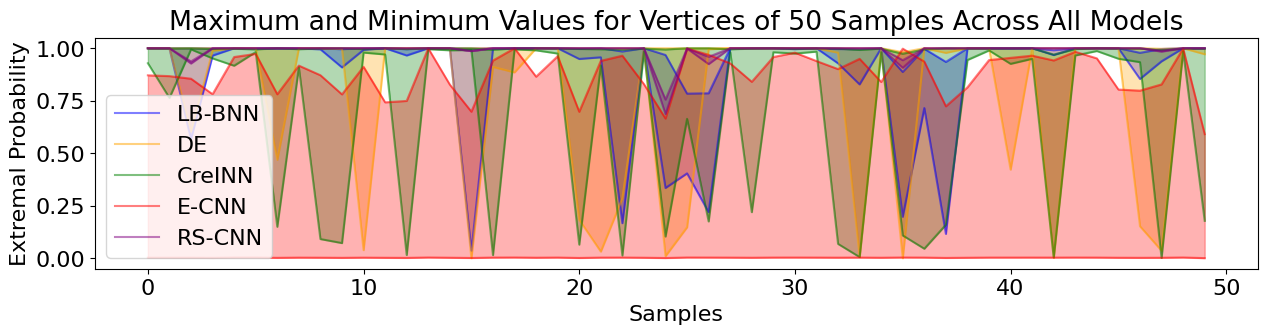

In [24]:
plt.rcParams.update({'font.size': 16})

models_vertices = {
    "LB-BNN": lbbnn_vertices,
    "DE": de_vertices,
    "CreINN": creinn_vertices,
    "E-CNN": ecnn_vertices,
    "RS-CNN": rscnn_vertices
}

models = {
    "LB-BNN": lbbnn_100_class_preds,
    "DE": de_15_class_preds,
    "CreINN": creinn_class_preds,
    "E-CNN": ecnn_class_preds,
    "RS-CNN": rscnn_class_preds
}

colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plot maximum and minimum values for all models
plt.figure(figsize=(15, 3))
for i, (model_name, model_vertices) in enumerate(models_vertices.items()):
    # Adjust the number of samples
    model_vertices_100 = model_vertices[:50]
    
    max_values =  []
    min_values = []
    for j,v in enumerate(model_vertices_100):
        pred_class = models[model_name][j]
        max_values.append(v[pred_class*2, pred_class])
        min_values.append(v[(pred_class*2)+1, pred_class])
        
    plt.plot(max_values, color=colors[i], label=f'{model_name}', alpha=0.5)
    plt.plot(min_values, color=colors[i], alpha=0.5)
    
    plt.fill_between(range(len(max_values)), max_values, min_values, color=colors[i], alpha=0.3)
    

plt.xlabel('Samples')
plt.ylabel('Extremal Probability')
plt.title('Maximum and Minimum Values for Vertices of 50 Samples Across All Models')
plt.legend()
plt.show()

## KL DIVERGENCE

In [25]:
# Calculating KL divergence between ground truth and epistemic predictions
kl_divs_models = {}
near_vertex_kl_models = {}

# Define a function to compute KL divergence for a given model
def compute_kl_div(vertices_list):
    epsilon = 1e-10 
    vertices_list = np.clip(vertices_list, a_max=None, a_min=epsilon)
    if np.sum(vertices_list==0) != 0:
        print(np.sum(vertices_list==0))
    return np.min(np.sum(y_test_one_hot[:,None, :] * np.log((y_test_one_hot[:, None, :]+epsilon) / vertices_list), axis=-1), axis=-1)

# Compute KL divergence and nearest vertex for each model
for model_name, vertices_list in tqdm(models_vertices.items()):
    kl_divs_models[model_name] = compute_kl_div(vertices_list)

100%|██████████| 5/5 [00:00<00:00, 34.20it/s]


In [26]:
# Compute KL distance for point predictions
kl_divs_models_point_preds = {}

model_names = ["CNN", "LB-BNN Avg", "DE Avg"]
model_preds = [cnn_preds, lbbnn_cifar10_bmaveraged, de_cifar10_averaged]

for model_name, model_p in zip(model_names, model_preds):
    kl_divs_models_point_preds[model_name] = compute_kl_div(model_p[:, None, :])

In [27]:
# Print first 5 KL Divergences for all models
for model_name in kl_divs_models:
    print(f"Model: {model_name}")
    print("KL Divergence:", np.mean(kl_divs_models[model_name]), np.std(kl_divs_models[model_name]))

for model_name in kl_divs_models_point_preds:
    print(f"Model: {model_name}")
    print("KL Divergence:", np.mean(kl_divs_models_point_preds[model_name]), np.std(kl_divs_models_point_preds[model_name]))

Model: LB-BNN
KL Divergence: 0.24267903 1.3150367
Model: DE
KL Divergence: 0.03058259 0.36747164
Model: CreINN
KL Divergence: 0.05783756 0.37373295
Model: E-CNN
KL Divergence: 0.19318381 0.21494383
Model: RS-CNN
KL Divergence: 0.39830443 1.8949592
Model: CNN
KL Divergence: 0.48061 1.7964994
Model: LB-BNN Avg
KL Divergence: 0.41954023 1.5194741
Model: DE Avg
KL Divergence: 0.19508088 0.7631316


In [28]:
# Correctly Classified (CC) and Incorrectly Classified (ICC) samples
models = {
    "LB-BNN": lbbnn_100_class_preds,
    "DE": de_15_class_preds,
    "CreINN": creinn_class_preds,
    "E-CNN": ecnn_class_preds,
    "RS-CNN": rscnn_class_preds
}

point_preds = {
    "CNN": cnn_class_preds,
    "LB-BNN Avg": lbbnn_bma_class_preds,
    "DE Avg": de_averaged_class_preds
}

incorrect_indices = {}
correct_indices = {}
incorrect_indices_avg = {}
correct_indices_avg = {}

for model_name, model_preds in models.items():
    incorrect_idx = np.nonzero(model_preds != y_test)[0]
    incorrect_indices[model_name] = incorrect_idx
    
    correct_idx = np.nonzero(model_preds == y_test)[0]
    correct_indices[model_name] = correct_idx

for model_name_point, model_preds_point in point_preds.items():
    incorrect_idx_avg = np.nonzero(model_preds_point != y_test)[0]
    incorrect_indices_avg[model_name_point] = incorrect_idx_avg
    
    correct_idx_avg = np.nonzero(model_preds_point == y_test)[0]
    correct_indices_avg[model_name_point] = correct_idx_avg

print("Incorrectly Classified (ICC)")
for model_name, incorrect_idx in incorrect_indices.items():
    print(f"Number of incorrectly classified samples for {model_name}: {len(incorrect_idx)}")
for model_name_point, incorrect_idx_point in incorrect_indices_avg.items():
    print(f"Number of incorrectly classified samples for {model_name_point}: {len(incorrect_idx_point)}")

print("Correctly Classified (CC)")
for model_name, correct_idx in correct_indices.items():
    print(f"Number of correctly classified samples for {model_name}: {len(correct_idx)}")
for model_name_point, correct_idx_point in correct_indices_avg.items():
    print(f"Number of correctly classified samples for {model_name_point}: {len(correct_idx_point)}")

Incorrectly Classified (ICC)
Number of incorrectly classified samples for LB-BNN: 1076
Number of incorrectly classified samples for DE: 623
Number of incorrectly classified samples for CreINN: 1164
Number of incorrectly classified samples for E-CNN: 1650
Number of incorrectly classified samples for RS-CNN: 701
Number of incorrectly classified samples for CNN: 975
Number of incorrectly classified samples for LB-BNN Avg: 1073
Number of incorrectly classified samples for DE Avg: 623
Correctly Classified (CC)
Number of correctly classified samples for LB-BNN: 8924
Number of correctly classified samples for DE: 9377
Number of correctly classified samples for CreINN: 8836
Number of correctly classified samples for E-CNN: 8350
Number of correctly classified samples for RS-CNN: 9299
Number of correctly classified samples for CNN: 9025
Number of correctly classified samples for LB-BNN Avg: 8927
Number of correctly classified samples for DE Avg: 9377


<Figure size 1200x800 with 0 Axes>

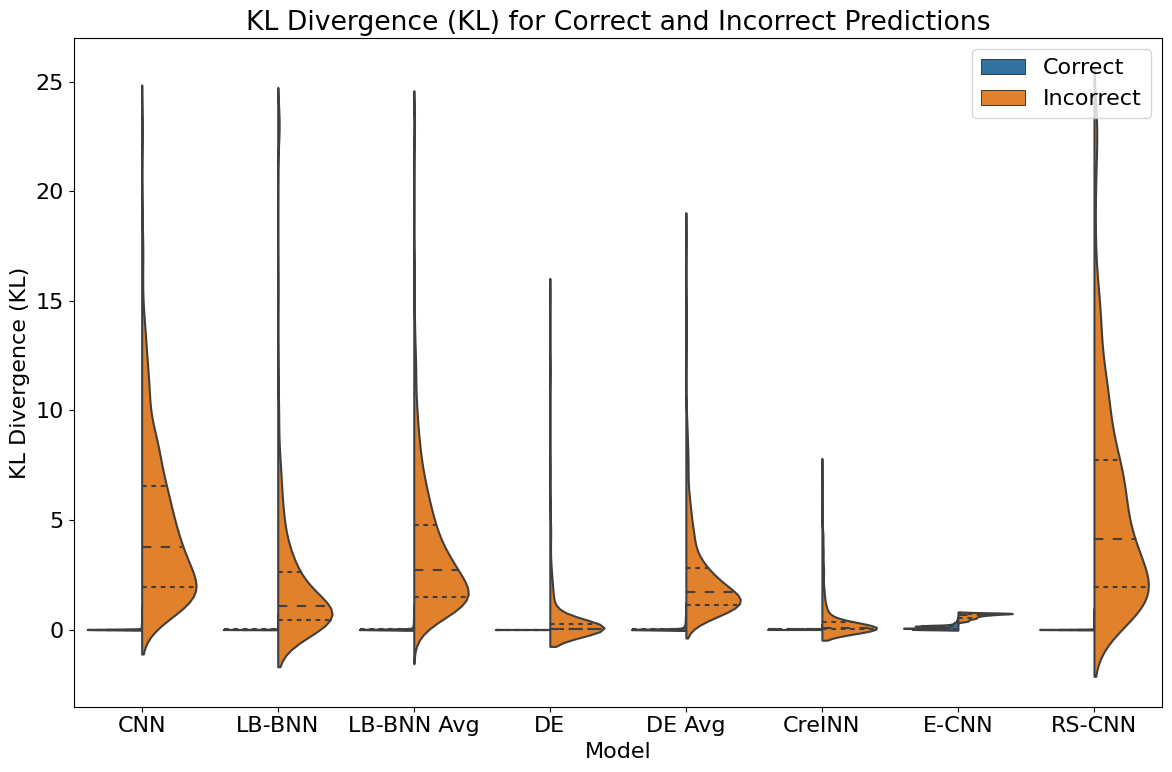

In [29]:
# Plot all KL divergences for correct and incorrect predictions across models
correct_kl_divs = []
incorrect_kl_divs = []
model_names_correct = []
model_names_incorrect = []

for model_name in models:
    correct_kl_divs.extend(kl_divs_models[model_name][correct_indices[model_name]])
    incorrect_kl_divs.extend(kl_divs_models[model_name][incorrect_indices[model_name]])
    model_names_correct.extend([model_name] * len(kl_divs_models[model_name][correct_indices[model_name]]))
    model_names_incorrect.extend([model_name] * len(kl_divs_models[model_name][incorrect_indices[model_name]]))

for model_name in point_preds:
    correct_kl_divs.extend(kl_divs_models_point_preds[model_name][correct_indices_avg[model_name]])
    incorrect_kl_divs.extend(kl_divs_models_point_preds[model_name][incorrect_indices_avg[model_name]])
    model_names_correct.extend([model_name] * len(kl_divs_models_point_preds[model_name][correct_indices_avg[model_name]]))
    model_names_incorrect.extend([model_name] * len(kl_divs_models_point_preds[model_name][incorrect_indices_avg[model_name]]))

# Create DataFrames for correct and incorrect KL divergences
df_correct = pd.DataFrame({
    'Model': model_names_correct,
    'KL Divergence': correct_kl_divs,
    'Type': ['Correct'] * len(correct_kl_divs)
})

df_incorrect = pd.DataFrame({
    'Model': model_names_incorrect,
    'KL Divergence': incorrect_kl_divs,
    'Type': ['Incorrect'] * len(incorrect_kl_divs)
})

# Concatenate correct and incorrect DataFrames
df_kl = pd.concat([df_correct, df_incorrect], ignore_index=True)
df_kl = df_kl.dropna()

# Plot the violin plot
plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x='Model', y='KL Divergence', hue='Type', data=df_kl.set_index("Model").loc[["CNN", "LB-BNN", "LB-BNN Avg", "DE", "DE Avg", "CreINN", "E-CNN", "RS-CNN"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=['Correct', False], density_norm="width", ax=ax)
sns.violinplot(x='Model', y='KL Divergence', hue='Type', data=df_kl.set_index("Model").loc[["CNN", "LB-BNN", "LB-BNN Avg", "DE", "DE Avg", "CreINN", "E-CNN", "RS-CNN"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=[False, 'Incorrect'], density_norm="width", ax=ax)
plt.title('KL Divergence (KL) for Correct and Incorrect Predictions')
ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
plt.xlabel('Model')
plt.ylabel('KL Divergence (KL)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## NON-SPECIFICITY

In [30]:
# Compute non-specificity
masses = {
    "LB-BNN": mass_lbbnn_100,
    "DE": mass_de_15,
    "CreINN": mass_creinn,
    "RS-CNN": mass_rscnn
}

def non_specific(models_preds_mass, new_classes):
    non_specif_all_models = {}
    for model_name, test_preds_mass in models_preds_mass.items():
        non_specif = []
        for i in range(len(test_preds_mass)):
            non_spec = 0
            for j, A in enumerate(new_classes):
                non_spec += test_preds_mass[i][j] * np.log(len(A))
            non_specif.append(non_spec)
        non_specif_all_models[model_name] = np.array(non_specif)
    return non_specif_all_models

non_specificity = non_specific(masses, new_classes_with_full)
non_specificity.update(non_specific({"E-CNN": mass_ecnn}, sets)) 

In [31]:
# The non-specificity for point predictions is zero
non_specificity["CNN"] = np.zeros_like(y_test)
non_specificity["LB-BNN Avg"] = np.zeros_like(y_test)
non_specificity["DE Avg"] = np.zeros_like(y_test)

In [32]:
# Mean non-specificity
for model_name, non_spec_values in non_specificity.items():
    print(f"Model: {model_name}")
    print("Non-Specificity:", np.mean(non_spec_values), np.std(non_spec_values))

Model: LB-BNN
Non-Specificity: 0.16621622773704609 0.3980272283543192
Model: DE
Non-Specificity: 0.38465305428790814 0.7146169963131889
Model: CreINN
Non-Specificity: 0.5960899559602606 0.811655272257293
Model: RS-CNN
Non-Specificity: 0.008944351956413507 0.05222391541467891
Model: E-CNN
Non-Specificity: 1.6089262665392563 0.003082025958902224
Model: CNN
Non-Specificity: 0.0 0.0
Model: LB-BNN Avg
Non-Specificity: 0.0 0.0
Model: DE Avg
Non-Specificity: 0.0 0.0


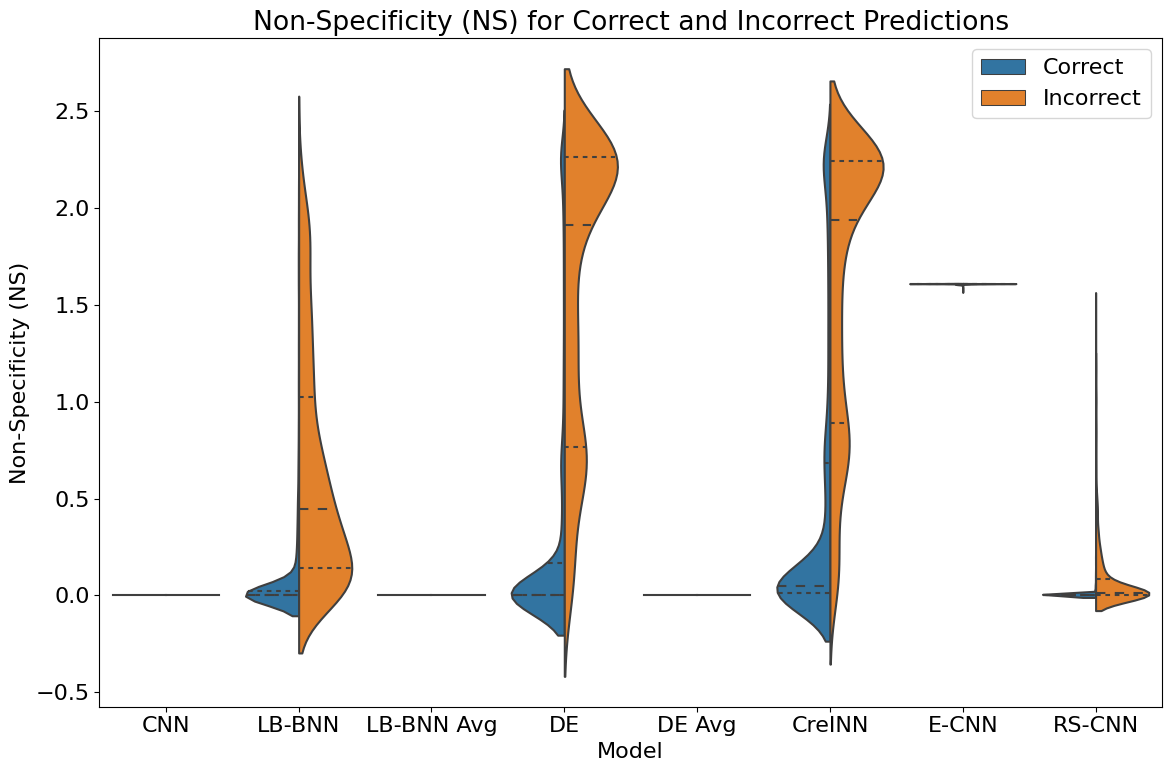

In [33]:
# Plot correct and incorrect non-specificity
correct_non_spec = []
incorrect_non_spec = []
model_names_correct = []
model_names_incorrect = []

for model_name in models:
    correct_non_spec.extend(non_specificity[model_name][correct_indices[model_name]])
    incorrect_non_spec.extend(non_specificity[model_name][incorrect_indices[model_name]])
    model_names_correct.extend([model_name] * len(non_specificity[model_name][correct_indices[model_name]]))
    model_names_incorrect.extend([model_name] * len(non_specificity[model_name][incorrect_indices[model_name]]))
    
for model_name in point_preds:
    correct_non_spec.extend(non_specificity[model_name][correct_indices_avg[model_name]])
    incorrect_non_spec.extend(non_specificity[model_name][incorrect_indices_avg[model_name]])
    model_names_correct.extend([model_name] * len(non_specificity[model_name][correct_indices_avg[model_name]]))
    model_names_incorrect.extend([model_name] * len(non_specificity[model_name][incorrect_indices_avg[model_name]]))


df_correct = pd.DataFrame({
    'Model': model_names_correct,
    'Non-Specificity': correct_non_spec,
    'Type': ['Correct'] * len(correct_non_spec)
})

df_incorrect = pd.DataFrame({
    'Model': model_names_incorrect,
    'Non-Specificity': incorrect_non_spec,
    'Type': ['Incorrect'] * len(incorrect_non_spec)
})

# Concatenate correct and incorrect DataFrames
df_spec = pd.concat([df_correct, df_incorrect], ignore_index=True)
df_spec = df_spec.dropna()

fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x='Model', y='Non-Specificity', hue='Type', data=df_spec.set_index("Model").loc[["CNN", "LB-BNN", "LB-BNN Avg", "DE", "DE Avg", "CreINN", "E-CNN", "RS-CNN"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=['Correct', False], density_norm="width", ax=ax)
sns.violinplot(x='Model', y='Non-Specificity', hue='Type', data=df_spec.set_index("Model").loc[["CNN", "LB-BNN", "LB-BNN Avg", "DE", "DE Avg", "CreINN", "E-CNN", "RS-CNN"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=[False, 'Incorrect'], density_norm="width", ax=ax)
ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
plt.title('Non-Specificity (NS) for Correct and Incorrect Predictions')
plt.xlabel('Model')
plt.ylabel('Non-Specificity (NS)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
## ECNN has similar non-spec for both correct and incorrect preds. very low variance in its non-spec, because the model always behaves imprecisely, while not giving much information.

<Figure size 1200x800 with 0 Axes>

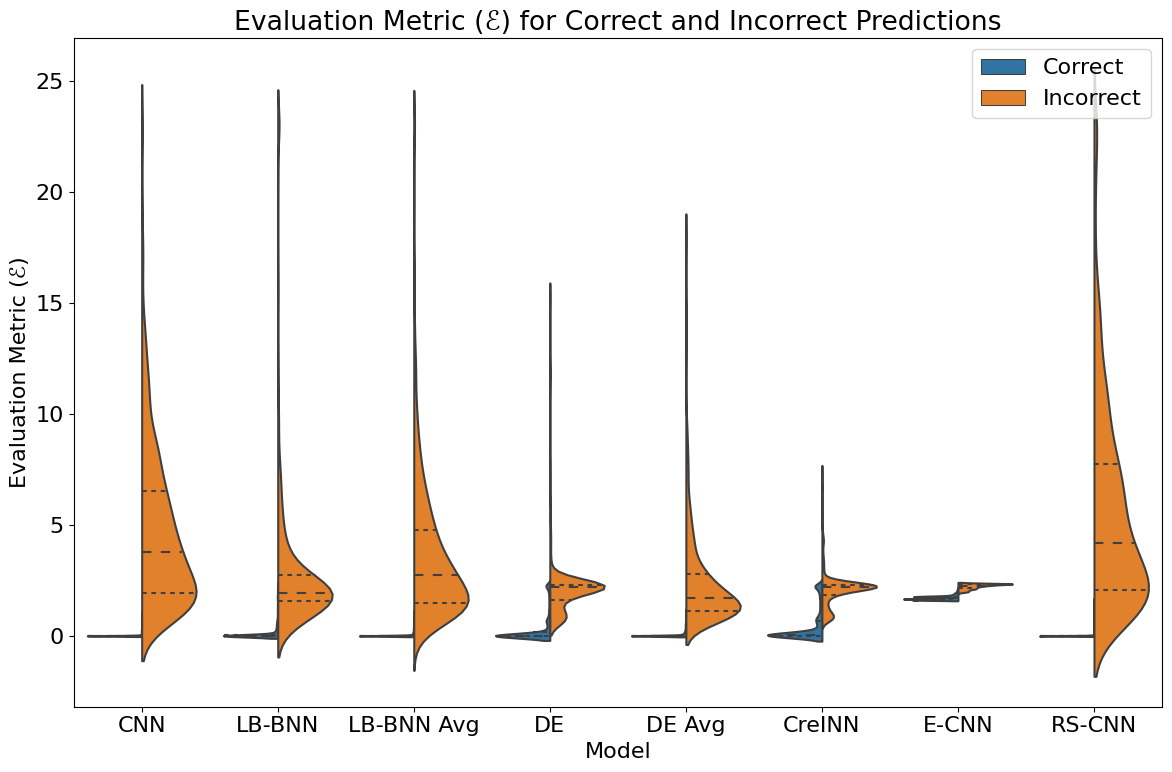

In [34]:
# Plot KL+NS
df_kl["combined"] = df_kl["KL Divergence"] + df_spec["Non-Specificity"] #\lambda = 1

# Plot the violin plot
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x='Model', y='combined', hue='Type', data=df_kl.set_index("Model").loc[["CNN", "LB-BNN", "LB-BNN Avg", "DE", "DE Avg", "CreINN", "E-CNN", "RS-CNN"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=['Correct', False], density_norm="width")
sns.violinplot(x='Model', y='combined', hue='Type', data=df_kl.set_index("Model").loc[["CNN", "LB-BNN", "LB-BNN Avg", "DE", "DE Avg", "CreINN", "E-CNN", "RS-CNN"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=[False, 'Incorrect'], density_norm="width")
plt.title('Evaluation Metric (\u2130) for Correct and Incorrect Predictions')
ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
plt.xlabel('Model')
plt.ylabel('Evaluation Metric (\u2130)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Credal Set Size vs. Non-Specificity

In [35]:
# Plot credal set size vs non-specificity
model_credal_widths = {}

# Plot maximum and minimum values for all models
for i, (model_name, model_vertices) in enumerate(models_vertices.items()):
    model_credal_widths[model_name] = []
    for j,v in enumerate(model_vertices):
        max_value_index = np.arange(num_classes)*2
        min_value_index = np.arange(num_classes)*2+1
        pred_class = models[model_name][j]
        max_values = v[max_value_index, np.arange(num_classes)]
        min_values = v[min_value_index, np.arange(num_classes)]
        model_credal_widths[model_name].append(np.mean(max_values-min_values))

    model_credal_widths[model_name] = np.array(model_credal_widths[model_name])        

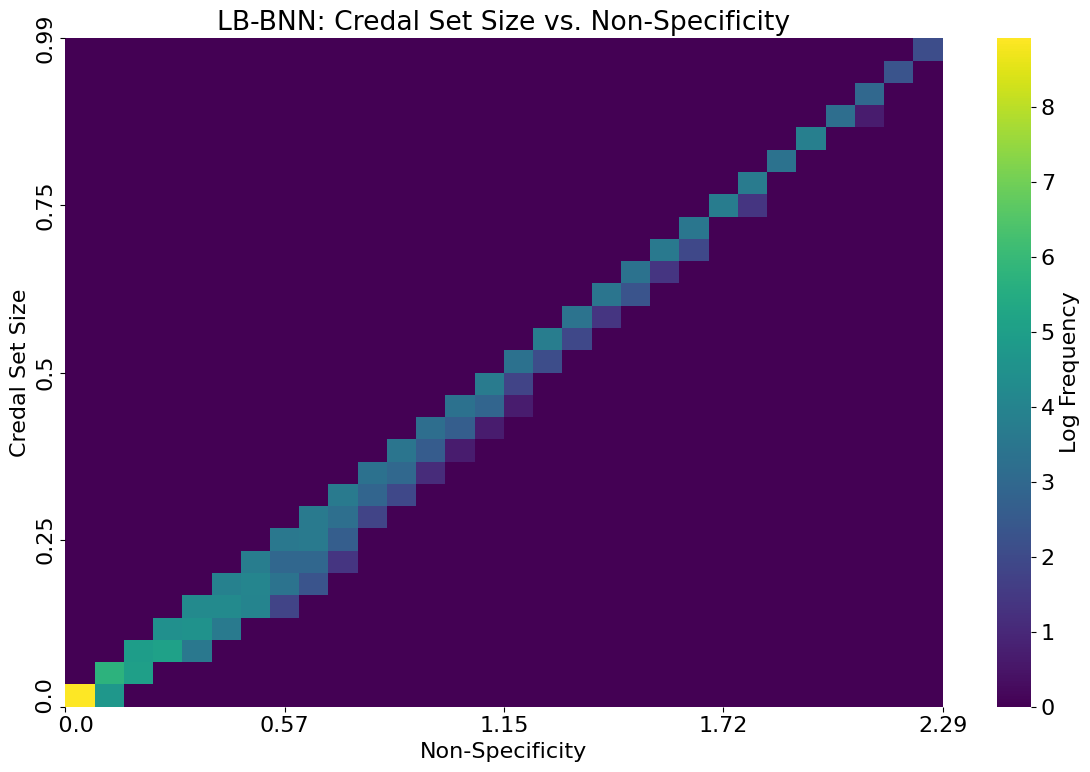

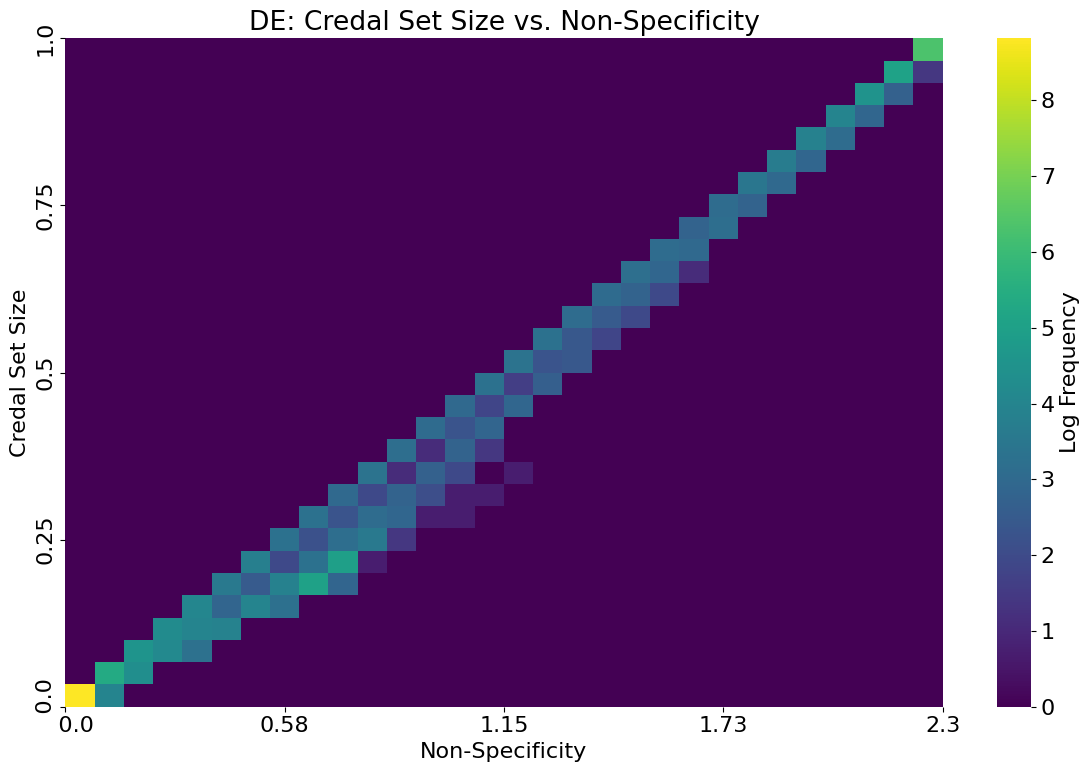

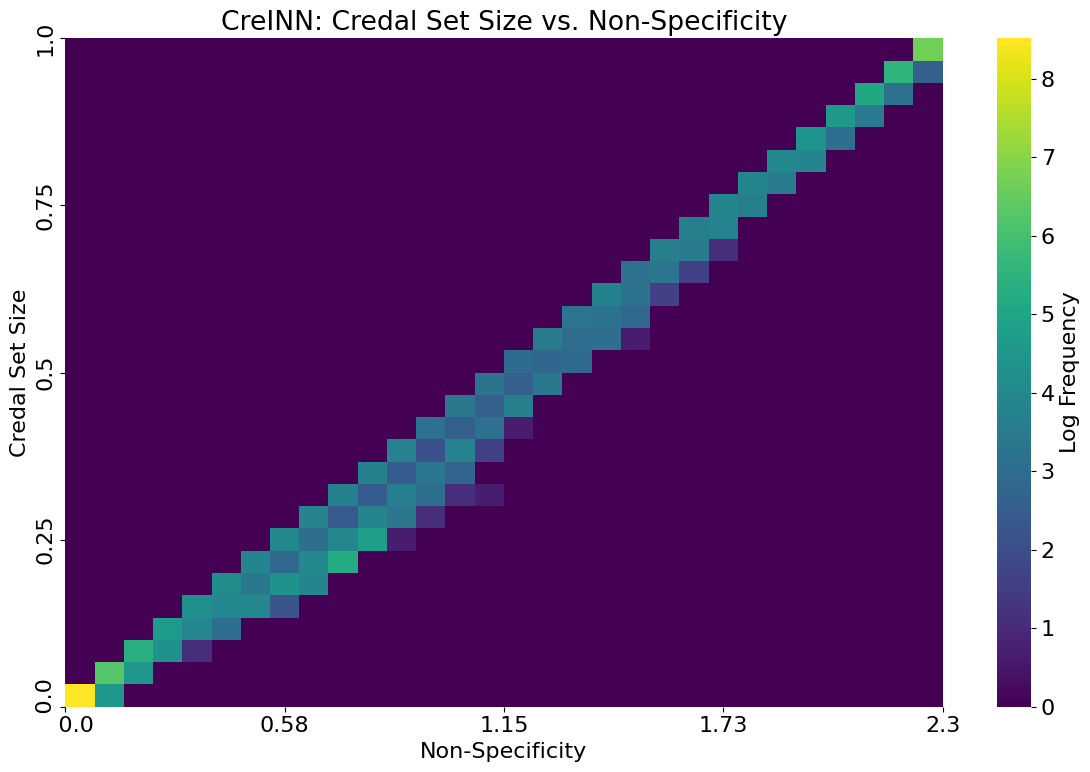

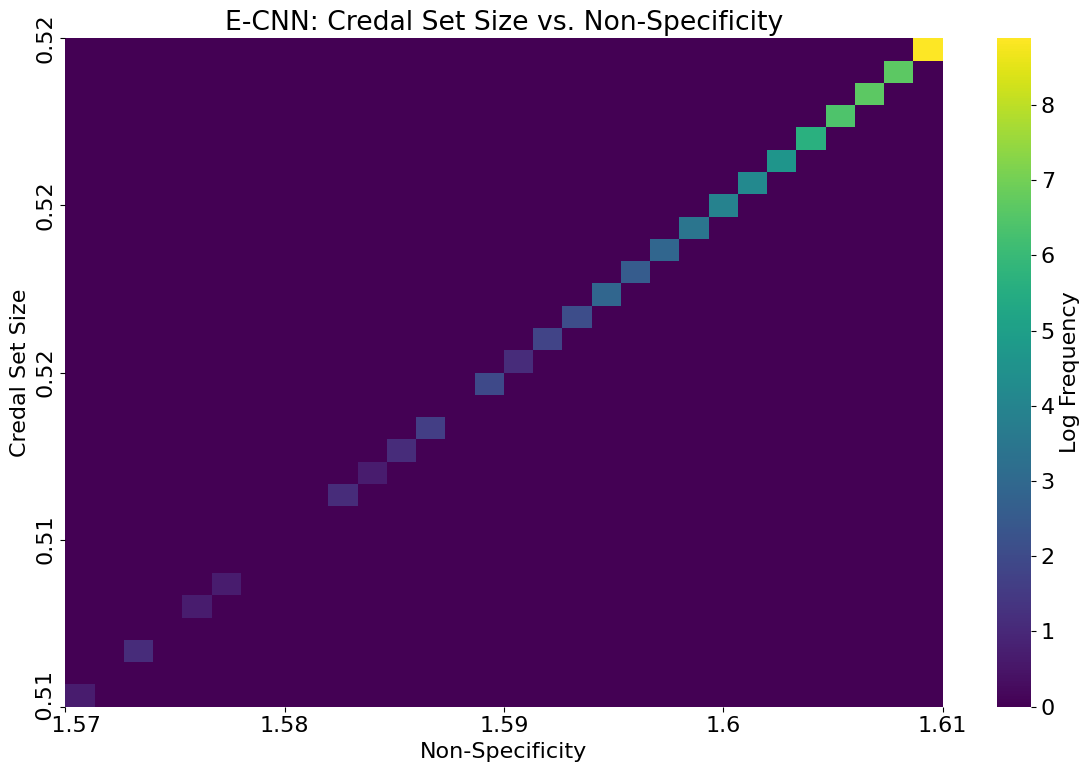

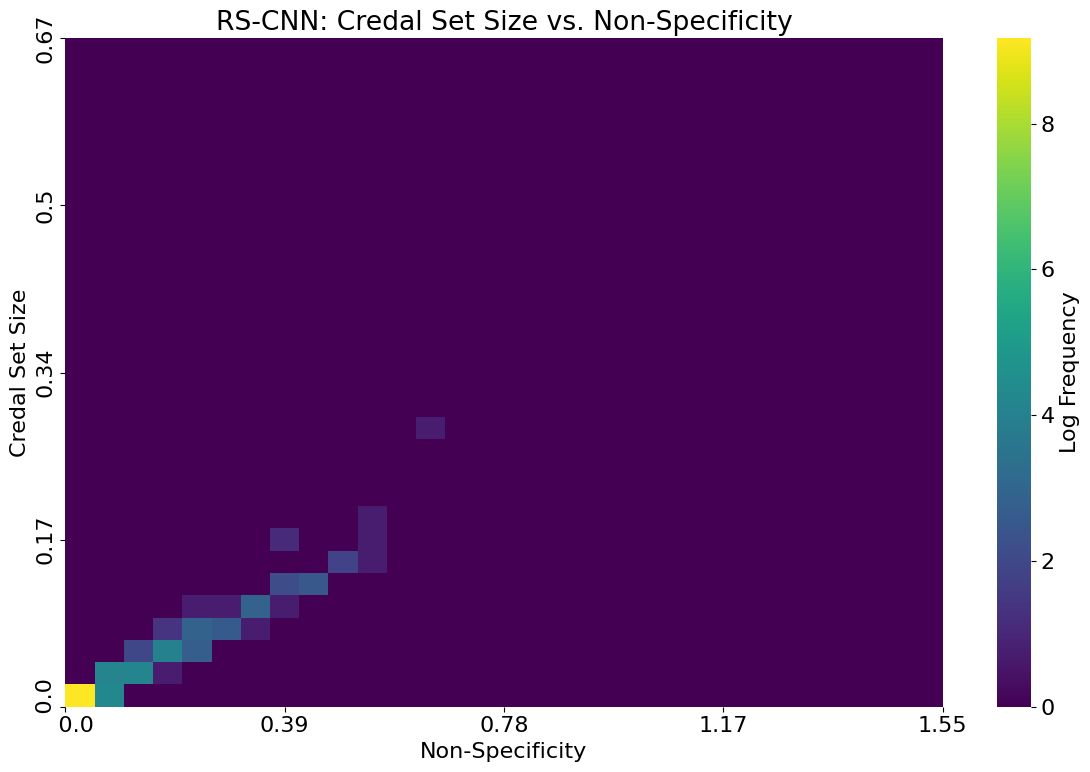

In [36]:
for model_name in model_credal_widths:
    fig, ax = plt.subplots(figsize=(12, 8))
    base = np.e
    hist_vals = np.emath.logn(base, np.histogram2d(non_specificity[model_name], model_credal_widths[model_name], bins=30)[0].T + 1e-31)
    
    hist_vals = np.clip(hist_vals, a_min=0, a_max=None)
    
    col_name = "viridis"
    color_palette = sns.color_palette(col_name, as_cmap=True)
    # Create heatmaps with normalized color scale
    sns.heatmap(data=hist_vals, cmap=color_palette, cbar=True, cbar_kws={'label': 'Log Frequency'}, vmin=0, vmax=np.max(hist_vals), ax=ax)
    
    ax.set_title(f"{model_name}: Credal Set Size vs. Non-Specificity")
    # Remove bin sizes on axes
    ax.set_xticks(np.linspace(0,30,5))
    x_tick_labels = list(np.round(np.linspace(np.min(non_specificity[model_name]),np.max(non_specificity[model_name]),5), 2))
    x_tick_labels[0] = f"   {x_tick_labels[0]}"
    ax.set_xticklabels(x_tick_labels, rotation = 0)
    
    ax.set_yticks(np.linspace(0,30,5))
    y_tick_labels = list(np.round(np.linspace(np.min(model_credal_widths[model_name]),np.max(model_credal_widths[model_name]),5), 2))
    y_tick_labels[0] = f"   {y_tick_labels[0]}"
    ax.set_yticklabels(y_tick_labels)
    
    ax.set_xlabel("Non-Specificity")
    ax.invert_yaxis()
    ax.set_ylabel("Credal Set Size")  
    plt.tight_layout()
    plt.show()

## EVALUATION METRIC

In [37]:
def calculate_eval_metric(kl_divs_models, non_specific_models, lamda_values):
    eval_metrics = {}
    for model_name, kl_divs in kl_divs_models.items():
        eval_metrics[model_name] = {}
        for lamda in lamda_values:
            eval_metric = kl_divs + lamda * non_specific_models[model_name]
            eval_metrics[model_name][lamda] = eval_metric
    return eval_metrics

# Define lambda values
lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate evaluation metric for all models
eval_metrics = calculate_eval_metric(kl_divs_models, non_specificity, lambda_values)

In [38]:
# Print evaluation metrics for all models
for model_name, lambda_metrics in eval_metrics.items():
    print(f"Model: {model_name}")
    for lambda_val, metric in lambda_metrics.items():
        print(f"Lambda: {lambda_val}, Eval Metric: {metric[:3]}")

Model: LB-BNN
Lambda: 0, Eval Metric: [1.47818428e-05 0.00000000e+00 6.92604517e-04]
Lambda: 0.1, Eval Metric: [2.13252333e-05 2.73180248e-08 3.08242949e-02]
Lambda: 0.2, Eval Metric: [2.78686239e-05 5.46360496e-08 6.09559853e-02]
Lambda: 0.3, Eval Metric: [3.44120145e-05 8.19540744e-08 9.10876757e-02]
Lambda: 0.4, Eval Metric: [4.09554051e-05 1.09272099e-07 1.21219366e-01]
Lambda: 0.5, Eval Metric: [4.74987957e-05 1.36590124e-07 1.51351056e-01]
Lambda: 0.6, Eval Metric: [5.40421863e-05 1.63908149e-07 1.81482747e-01]
Lambda: 0.7, Eval Metric: [6.05855769e-05 1.91226174e-07 2.11614437e-01]
Lambda: 0.8, Eval Metric: [6.71289674e-05 2.18544198e-07 2.41746128e-01]
Lambda: 0.9, Eval Metric: [7.36723580e-05 2.45862223e-07 2.71877818e-01]
Lambda: 1, Eval Metric: [8.02157486e-05 2.73180248e-07 3.02009508e-01]
Model: DE
Lambda: 0, Eval Metric: [0.00000000e+00 0.00000000e+00 5.96046334e-07]
Lambda: 0.1, Eval Metric: [1.63232917e-05 1.07490815e-07 2.77835452e-02]
Lambda: 0.2, Eval Metric: [3.2646

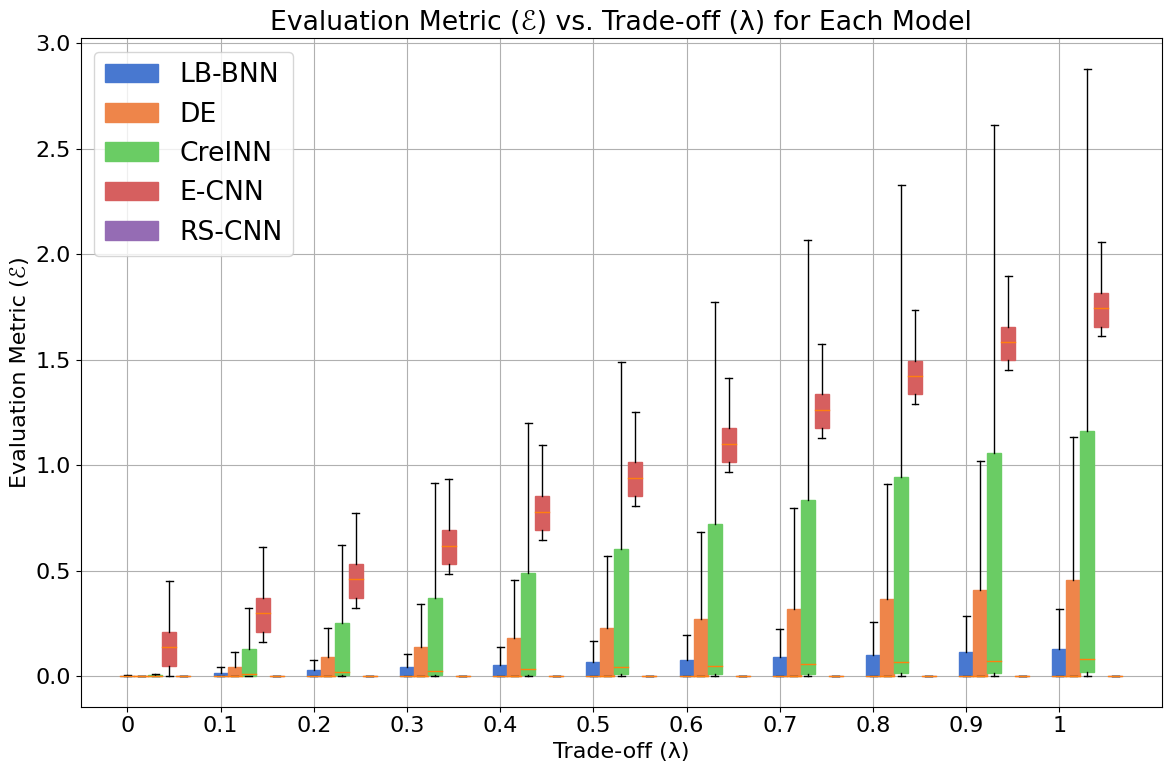

In [39]:
# Plot Evaluation Metric for different values of \lambda
palette = sns.color_palette("muted", n_colors=len(eval_metrics))

# Plot box plot for each model
plt.figure(figsize=(12, 8))
for i, (model_name, lamda_metrics) in enumerate(eval_metrics.items()):
    model_evals = [lamda_metrics[lamda] for lamda in lambda_values]
    bp = plt.boxplot(model_evals, positions=[lambda_val + i * 0.15 for lambda_val in range(len(lambda_values))], widths=0.15, showfliers=False, patch_artist=True)
    
    for box in bp['boxes']:
        box.set_color(palette[i])

# Create custom legend patches
legend_patches = [mpatches.Patch(color=palette[i], label=model_name) for i, model_name in enumerate(eval_metrics.keys())]

# Add legend with custom patches
plt.legend(handles=legend_patches, loc='upper left', fontsize='large')

plt.xlabel('Trade-off (\u03bb)')
plt.ylabel('Evaluation Metric (\u2130)')
plt.title('Evaluation Metric (\u2130) vs. Trade-off (\u03bb) for Each Model')
plt.grid(True)
plt.xticks(ticks=range(len(lambda_values)), labels=[str(l) for l in lambda_values])
plt.tight_layout()
plt.show()


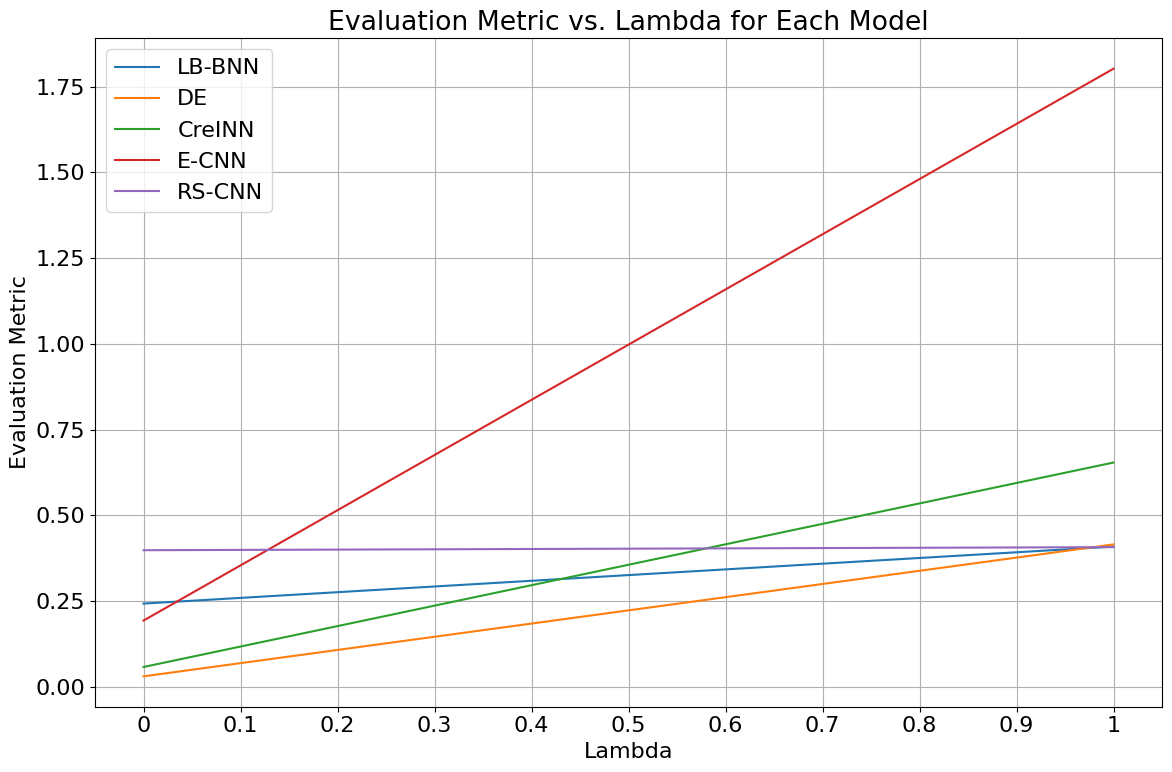

In [40]:
# Line plot for Evaluation Metric vs non-specificity
# Define a muted color palette
palette = sns.color_palette("muted", n_colors=len(eval_metrics))

# Plot box plot for each model
plt.figure(figsize=(12, 8))
for i, model_name in enumerate(eval_metrics):
    plt.plot(np.mean(np.array(list(eval_metrics[model_name].values())), axis=-1), label=model_name)

plt.legend()

plt.xlabel('Lambda')
plt.ylabel('Evaluation Metric')
plt.title('Evaluation Metric vs. Lambda for Each Model')
# plt.xlim([-0.8,1.5])
plt.grid(True)
plt.xticks(ticks=range(len(lambda_values)), labels=[str(l) for l in lambda_values])
plt.tight_layout()
plt.show()


## ABLATION STUDY

In [41]:
# Load saved evaluation metric for different number of samples (LB-BNN) and ensembles (DE)
eval_lbbnn_values_50 = np.load('/home/shireen/RS-CNN/Evaluation/eval_lbbnn_values_50.npy')
eval_lbbnn_values_100 = np.load('/home/shireen/RS-CNN/Evaluation/eval_lbbnn_values_100.npy')
eval_lbbnn_values_150 = np.load('/home/shireen/RS-CNN/Evaluation/eval_lbbnn_values_150.npy')
eval_lbbnn_values_200 = np.load('/home/shireen/RS-CNN/Evaluation/eval_lbbnn_values_200.npy')
eval_lbbnn_values_300 = np.load('/home/shireen/RS-CNN/Evaluation/eval_lbbnn_values_300.npy')
eval_lbbnn_values_400 = np.load('/home/shireen/RS-CNN/Evaluation/eval_lbbnn_values_400.npy')
eval_lbbnn_values_500 = np.load('/home/shireen/RS-CNN/Evaluation/eval_lbbnn_values_500.npy')

eval_de_values_5 = np.load('/home/shireen/RS-CNN/Evaluation/eval_de_values_5.npy')
eval_de_values_10 = np.load('/home/shireen/RS-CNN/Evaluation/eval_de_values_10.npy')
eval_de_values_15 = np.load('/home/shireen/RS-CNN/Evaluation/eval_de_values_15.npy')
eval_de_values_20 = np.load('/home/shireen/RS-CNN/Evaluation/eval_de_values_20.npy')
eval_de_values_25 = np.load('/home/shireen/RS-CNN/Evaluation/eval_de_values_25.npy')
eval_de_values_30 = np.load('/home/shireen/RS-CNN/Evaluation/eval_de_values_30.npy')

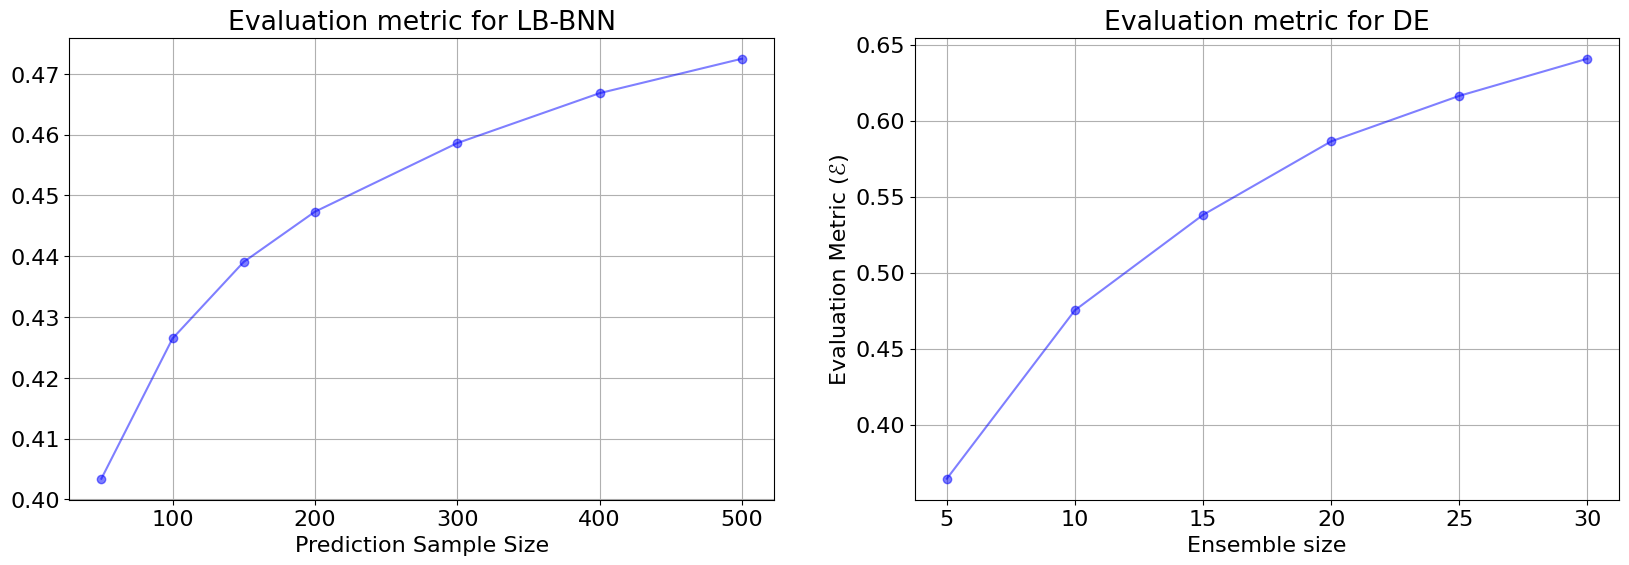

In [42]:
# Plot evaluation metric for different number of samples (LB-BNN) and ensembles (DE)
lb_bnn_sample_sizes = [50, 100, 150, 200, 300, 400, 500]
de_sample_sizes = [5, 10, 15, 20, 25, 30]

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
all_vals = np.stack([eval_lbbnn_values_50, eval_lbbnn_values_100, eval_lbbnn_values_150, eval_lbbnn_values_200, eval_lbbnn_values_300, eval_lbbnn_values_400, eval_lbbnn_values_500])
axs[0].plot(lb_bnn_sample_sizes, np.mean(all_vals, axis=-1), marker='o', color="b", alpha=0.5, label=f'LB-BNN Sample 50')
axs[0].set_xlabel('Prediction Sample Size')
axs[1].set_ylabel('Evaluation Metric (\u2130)')
axs[0].set_title('Evaluation metric for LB-BNN')
axs[0].grid(True)

all_vals_de = np.stack([eval_de_values_5, eval_de_values_10, eval_de_values_15, eval_de_values_20, eval_de_values_25, eval_de_values_30])
axs[1].plot(de_sample_sizes, np.mean(all_vals_de, axis=-1), marker='o', color="b", alpha=0.5, label=f'DE Sample 50')

axs[1].set_xlabel('Ensemble size')
axs[1].set_ylabel('Evaluation Metric (\u2130)')
axs[1].set_title('Evaluation metric for DE')
axs[1].grid(True)

plt.show()
